# Computer Vision Assignment: Face Recognizer
## Import necessary libs and datasets

Let me show 40 different people.
images shape: (400, 64, 64), labels shape: (400,)


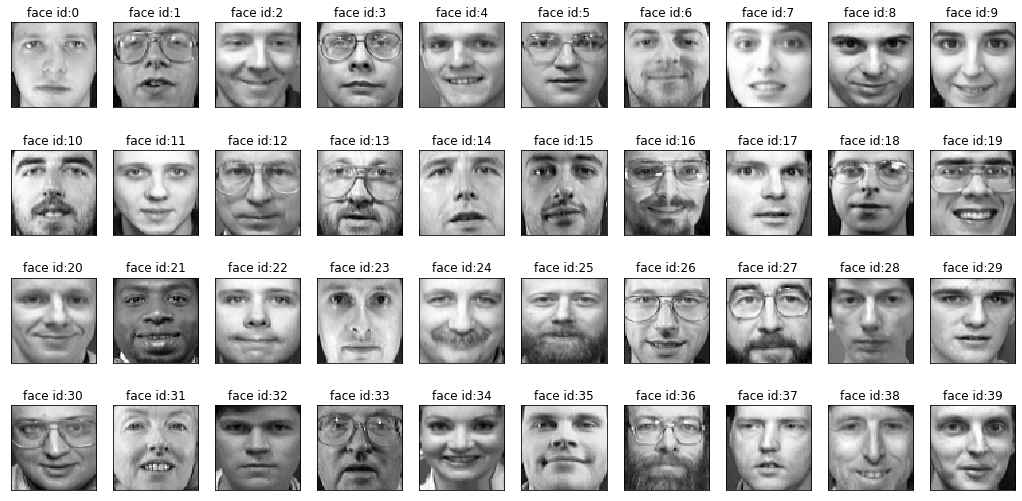

In [158]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

%matplotlib inline

olivetti = fetch_olivetti_faces()
images = olivetti.images
labels = olivetti.target

def show_40_distinct_people(images, unique_ids):
    #Creating 4X10 subplots in  18x9 figure size
    fig, axarr=plt.subplots(nrows=4, ncols=10, figsize=(18, 9))
    #For easy iteration flattened 4X10 subplots matrix to 40 array
    axarr=axarr.flatten()
    
    #iterating over user ids
    for unique_id in unique_ids:
        image_index=unique_id*10
        axarr[unique_id].imshow(images[image_index], cmap='gray')
        axarr[unique_id].set_xticks([])
        axarr[unique_id].set_yticks([])
        axarr[unique_id].set_title("face id:{}".format(unique_id))
        
print(f"Let me show {len(np.unique(labels))} different people.")
show_40_distinct_people(images, np.unique(labels))

print(f"images shape: {images.shape}, labels shape: {labels.shape}")

## train, test split
### 평가에 사용할 예정이니 트레인, 테스트 스플릿 코드는 그대로 유지시켜주세요

In [159]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, random_state=0,
                                                   stratify=labels, test_size=0.1)

print(len(X_train), len(X_test))

360 40


In [160]:
(X_train.shape,y_train.shape),(X_test.shape,y_test.shape)

(((360, 64, 64), (360,)), ((40, 64, 64), (40,)))

## training
### Data Augmentation
#### 뉴럴 네트워크를 훈련시키는데 360개의 인스턴스는 턱없이 부족합니다. 
#### 따라서 `torchvision`의 `transforms`를 이용해서 data augmentation을 해주세요.

In [161]:
# importing the libraries
import pandas as pd
import numpy as np
from skimage.io import imread, imsave
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage
from skimage.transform import rotate, AffineTransform, warp

import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader


In [162]:
final_train_data = []
final_target_train = []
for i in tqdm(range(X_train.shape[0])):
    final_train_data.append(X_train[i])
    
    transform_25 = AffineTransform(translation=(25,25)) #shifted the image by (50, 50) pixels
    transform_50 = AffineTransform(translation=(50,50)) #shifted the image by (50, 50) pixels
    transform_75 = AffineTransform(translation=(75,75)) #shifted the image by (75, 75) pixels
    
    final_train_data.append(rotate(X_train[i], angle=45, mode = 'wrap'))
    final_train_data.append(rotate(X_train[i], angle=90, mode = 'wrap'))
    final_train_data.append(rotate(X_train[i], angle=270, mode = 'wrap')) 
    final_train_data.append(warp(X_train[i],transform_25,mode='wrap'))
    final_train_data.append(warp(X_train[i],transform_50,mode='wrap'))
    final_train_data.append(warp(X_train[i],transform_75,mode='wrap'))
    #Setting mode as ‘wrap’ fills the points outside the boundaries of the input with the remaining pixels of the image
    final_train_data.append(np.fliplr(X_train[i])) #flip left to right
    final_train_data.append(np.flipud(X_train[i])) #rotate angle=180과 동일
    final_train_data.append(random_noise(X_train[i],var=0.2**2)) #add random noise
    final_train_data.append(random_noise(X_train[i],var=0.5**2))
    final_train_data.append(gaussian(X_train[i],sigma=1,multichannel=True)) #blur image
    for j in range(12):
        final_target_train.append(y_train[i])

#generated 11 augmented images for each of 360 images in the training set

100%|███████████████████████████████████████████████████████████████████████████████| 360/360 [00:02<00:00, 131.06it/s]


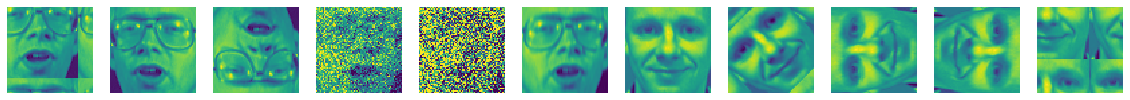

In [163]:
#visualization
fig,ax = plt.subplots(nrows=1,ncols=11,figsize=(20,20))
for i in range(11):
    ax[i].imshow(final_train_data[i+30])
    ax[i].axis('off')

In [164]:
X_train = np.array(final_train_data)
y_train = np.array(final_target_train)
len(X_train), len(y_train)
(X_train.shape,y_train.shape)

((4320, 64, 64), (4320,))

In [165]:
X_train = X_train.reshape(4320,-1,64,64)
print(X_train.shape)

(4320, 1, 64, 64)


In [166]:
import torch
from torch import nn, optim
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

#compose = transforms.Compose([
   # transforms.ToTensor(),
  #  torchvision.transforms.Resize((224,224)),
  #  torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
  #  torchvision.transforms.RandomHorizontalFlip(),
  #  torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
#])


[data augmentation 참고 링크(1)](https://www.analyticsvidhya.com/blog/2019/12/image-augmentation-deep-learning-pytorch/) <br>
[data augmentation 참고 링크(2)](https://colab.research.google.com/drive/109vu3F1LTzD1gdVV6cho9fKGx7lzbFll)

### 함수의 빈칸을 채워가면서 FaceDataset, FaceClassifier를 만들어주세요.

In [167]:
class FaceDataset(Dataset):
    def __init__ (self, images, labels, transform=None):
        self.images = torch.from_numpy(images)
        self.labels = torch.from_numpy(labels)
        self.transform = transform
        self.len = len(images)
         
    def __len__(self):
        return (self.len)
    
    def __getitem__(self,idx):
        return self.images[idx], self.labels[idx]


In [168]:
torch.manual_seed(0)

from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, MaxPool1d, Conv2d, MaxPool2d, Module, Softmax, BatchNorm1d,BatchNorm2d, Dropout

class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm1d(32),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(64),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
            # Defining another 2D convolution layer
            Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            ReLU(inplace=True),
            # adding batch normalization
            BatchNorm2d(128),
            MaxPool2d(kernel_size=2, stride=2),
            # adding dropout
            Dropout(p=0.25),
        )

        #Max pooling 4번 64-32-16-8-4=4
        self.linear_layers = Sequential(
            Linear(128 * 4 * 4, 512),
            ReLU(inplace=True),
            Dropout(),
            Linear(512, 256),
            ReLU(inplace=True),
            Dropout(),
            Linear(256,128),
            ReLU(inplace=True),
            Dropout(),
            Linear(128,40) #class는 40개
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [169]:
from torch.optim import Adam, SGD
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# defining the model
model = Net()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.0001)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25, inplace=False)
    (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.25, inplace=False)
    (15): Con

### 적절한 parameter를 사용해서 dataset과 train에 쓸 DataLoader를 만들어주세요.
### FaceDataset, DataLoader 생성자에 들어갈 parameter는 적당히 넣어주세요.

In [171]:
dataset = FaceDataset(images=X_train, labels=y_train) 
data_loader = DataLoader(dataset=dataset, batch_size=20,shuffle=True,drop_last=True)

### 360+$\alpha$개의 훈련 인스턴스를 사용해서 train 함수를 통해 training을 해주시고,
### eval 함수를 통해 40개의 test example에 대해서 accuracy를 측정해주세요.
### 함수 및 클래스 signature와 내부 코드는 적절히 알아서 짜주시면 됩니다.

In [172]:
torch.manual_seed(0)

# batch size of the model
batch_size = 20

# number of epochs to train the model
n_epochs = 20

for epoch in range(1, n_epochs+1):

    avg_cost = 0
    
    for i, data in enumerate(data_loader,0):
        
        X_train ,y_train = data
        X_train = X_train.reshape(-1,1,64,64)
        y_train = y_train
        
        optimizer.zero_grad()
        hypothesis = model(X_train.float())
        cost = criterion(hypothesis, y_train.long())
        cost.backward()
        optimizer.step()

        avg_cost += cost / total_batch

    print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))

print('Learning Finished!')

ValueError: expected 2D or 3D input (got 4D input)

In [173]:
X_train.shape

torch.Size([20, 1, 64, 64])